In [1]:
import dynamax
import jax.numpy as jnp
import jax.random as jr
import inference
from functools import partial

from jax import vmap, tree_map, jit
from dynamax.linear_gaussian_ssm.inference import ParamsLGSSM, make_lgssm_params
# import MVN from tfd
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN

import seaborn as sns
import matplotlib.pyplot as plt
import mixture_kalman_filter as kflib
from functools import partial
from sklearn.preprocessing import OneHotEncoder
from jax.scipy.special import logit
from plot_utils import kdeg, style3d
import jax

# Simulate Data

In [2]:
TT = 0.1
A = jnp.array([[1, TT, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, TT],
            [0, 0, 0, 1]])


B1 = jnp.array([0, 0, 0, 0])
B2 = jnp.array([-1.225, -0.35, 1.225, 0.35])
B3 = jnp.array([1.225, 0.35,  -1.225,  -0.35])
B = jnp.stack([B1, B2, B3], axis=0)

Q = 0.2 * jnp.eye(4)
R = 10 * jnp.diag(jnp.array([2, 1, 2, 1]))
C = jnp.eye(4)


transition_matrix = jnp.array([
    [0.8, 0.1, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.1, 0.8]
])

params = kflib.RBPFParamsDiscrete(A, B, C, Q, R, transition_matrix)

nparticles = 1000
nsteps = 100
key = jr.PRNGKey(1)
keys = jr.split(key, nsteps)

x0 = (1, jr.multivariate_normal(key, jnp.zeros(4), jnp.eye(4)))
draw_state_fixed = partial(kflib.draw_state, params=params)

# Create target dataset
_, (latent_hist, state_hist, obs_hist) = jax.lax.scan(draw_state_fixed, x0, keys)

## Baseline implementation

In [3]:
# Perform filtering
key_base = jr.PRNGKey(31)
key_mean_init, key_sample, key_state, key_next = jr.split(key_base, 4)
p_init = jnp.array([0.0, 1.0, 0.0])

# Initial filter configuration
mu_0 = 0.01 * jr.normal(key_mean_init, (nparticles, 4))
Sigma_0 = jnp.zeros((nparticles, 4,4))
s0 = jr.categorical(key_state, logit(p_init), shape=(nparticles,))
weights_0 = jnp.ones(nparticles) / nparticles
init_config = (key_next, mu_0, Sigma_0, weights_0, s0)

rbpf_optimal_part = partial(kflib.rbpf_optimal, params=params, nparticles=nparticles)
_, (mu_hist, Sigma_hist, weights_hist, s_hist, Ptk) = jax.lax.scan(rbpf_optimal_part, init_config, obs_hist)
mu_hist_post_mean = jnp.einsum("ts,tsm->tm", weights_hist, mu_hist)

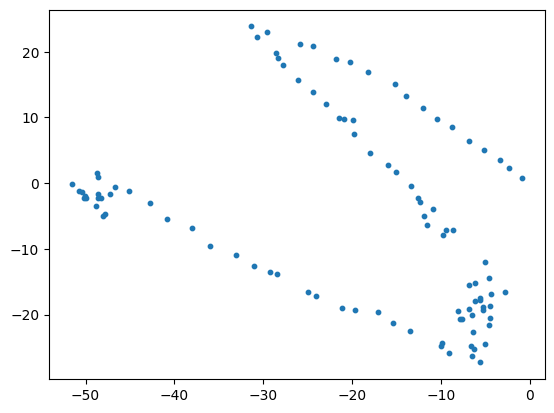

In [4]:
rbpf_mse = ((mu_hist_post_mean - state_hist)[:, [0, 2]] ** 2).mean(axis=0).sum()
latent_hist_est = Ptk.mean(axis=1).argmax(axis=1)
plt.scatter(*mu_hist_post_mean[:, [0, 2]].T, s=10)
plt.show()

## My implementation

In [5]:
num_states = 3
num_particles = 1000
state_dim = 4
emission_dim = 4

discr_params = inference.DiscreteParamsSLDS(
    initial = jnp.ones(num_states)/num_states,
    transition_matrix=transition_matrix,
    proposal_transition_matrix=transition_matrix
)

params_lds1 = make_lgssm_params(initial_mean = jnp.ones(state_dim),
                      initial_cov = jnp.eye(state_dim),
                      dynamics_weights = A,
                      dynamics_cov = Q,
                      emissions_weights = C,
                      emissions_cov = R,
                      dynamics_bias=B1,
                      dynamics_input_weights=None,
                      emissions_bias=None,
                      emissions_input_weights=None)
params_lds2 = make_lgssm_params(initial_mean = jnp.ones(state_dim),
                        initial_cov = jnp.eye(state_dim),
                        dynamics_weights = A,
                        dynamics_cov = Q,
                        emissions_weights = C,
                        emissions_cov = R,
                        dynamics_bias=B2,
                        dynamics_input_weights=None,
                        emissions_bias=None,
                        emissions_input_weights=None)
params_lds3 = make_lgssm_params(initial_mean = jnp.ones(state_dim),
                        initial_cov = jnp.eye(state_dim),
                        dynamics_weights = A,
                        dynamics_cov = Q,
                        emissions_weights = C,
                        emissions_cov = R,
                        dynamics_bias=B3,
                        dynamics_input_weights=None,
                        emissions_bias=None,
                        emissions_input_weights=None)

key = jr.PRNGKey(7)

params = inference.ParamsSLDS(
    discrete=discr_params,
    linear_gaussian=[params_lds1, params_lds2, params_lds3]
)
out = inference.rbpfilter(num_particles, params, obs_hist)

AttributeError: 'list' object has no attribute 'dynamics'

In [ ]:
means = out['means']
weights = out['weights']
my_post_mean = jnp.einsum("ts,tsm->tm", weights, means)

In [ ]:
myrbpf_mse = ((my_post_mean - state_hist)[:, [0, 2]] ** 2).mean(axis=0).sum()
latent_hist_est = Ptk.mean(axis=1).argmax(axis=1)
plt.scatter(*my_post_mean[:, [0, 2]].T, s=10)
plt.show()

In [ ]:
def my_func(x, y, p1, p2):
    return p1 * x + p2 * y

p1_array = jnp.array([1, 2, 3])
p2_array = jnp.array([4, 5, 6])
x_array = jnp.linspace(0, 1, 100)
y_array = jnp.linspace(0, 1, 100)

my_func_vmap = jax.vmap(my_func, in_axes=(0, 0, None, None))
my_func2 = vmap(lambda p1, p2: my_func_vmap(x_array, y_array, p1, p2), in_axes=(0, 0))
out = my_func2(p1_array, p2_array)
out

In [ ]:
def my_other_func(x,y):
    return x, x+y

my_other_func_vmap = jax.vmap(my_other_func, in_axes=(0, 0))
my_other_mapped_func = vmap(my_other_func, in_axes=(0, 0), out_axes=(0, 0))